In [2]:
# prompt: from colab import and mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%cd '/content/drive/MyDrive/Colab Notebooks/oficina_racismo_ambiental/dados/'

/content/drive/MyDrive/Colab Notebooks/oficina_racismo_ambiental/dados


In [14]:
import os
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/oficina_racismo_ambiental/dados


In [15]:
!ls


CodigosMuniRJ.csv


In [16]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import geopandas as gpd
from folium.plugins import HeatMap

In [17]:
# Configurações globais para visualização
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
plt.style.use("ggplot")

In [18]:
# Configurações globais
crs = {'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84'}
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use("ggplot")

In [19]:
# Funções Utilitárias

def carregar_dados(caminho_populacao, caminho_codigos):
    """Carrega os dados de população e códigos de municípios, realizando o tratamento inicial."""
    # Carregar os dados de população
    populacao = pd.read_excel(caminho_populacao)
    # Carregar os códigos dos municípios
    codigos = pd.read_csv(caminho_codigos).drop(columns=['Unnamed: 0'], errors='ignore')
    # Unir os dados com base no código IBGE
    dados = pd.merge(codigos, populacao, how='left', on='COD_IBGE')
    dados.info()  # Exibir informações básicas dos dados
    return dados

def calcular_populacao_negra(df):
    """Calcula a população negra total e percentual, somando as populações Preta e Parda."""
    df['NEGRA'] = df['PRETA'] + df['PARDA']
    df['NEGRA%'] = (df['NEGRA'] / df['TOTAL']) * 100
    return df

def ajustar_populacao(df, coluna):
    """Ajusta a população total para evitar duplicação de dados."""
    df[coluna] = df[coluna] // 2
    return df

def categorizar_percentual(df, coluna, percentis):
    """Classifica os municípios em faixas de percentuais com base nos percentis fornecidos."""
    categorias = pd.cut(
        df[coluna],
        bins=[0] + list(percentis) + [100],
        labels=[
            'Menor que 35%', '35% a 39%', '40% a 44%', '45% a 49%',
            '50% a 54%', '55% a 59%', '60% a 64%', '65% a 69%',
            '70% a 75%', 'Maior que 75%'
        ]
    )
    df['FAIXA_PERCENTUAL_NEGROS'] = categorias
    return df

def criar_mapa_choropleth(df, coluna_percentual, legenda, localizacao=[-22, -43], zoom_inicial=8):
    """Cria um mapa choropleth para visualização geoespacial dos dados."""
    mapa = folium.Map(location=localizacao, zoom_start=zoom_inicial)
    folium.Choropleth(
        geo_data='https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-33-mun.json',
        name='choropleth',
        data=df,
        columns=['id', coluna_percentual],
        key_on='properties.id',
        fill_color='YlOrBr',
        fill_opacity=0.7,
        line_opacity=0.5,
        legend_name=legenda
    ).add_to(mapa)
    return mapa

def exportar_dados(df, caminho_saida):
    """Exporta os dados para um arquivo Excel, ordenados pelo percentual de população negra."""
    df_ordenado = df.sort_values(by='NEGRA%', ascending=False)
    df_ordenado.to_excel(caminho_saida, index=False)
    print(f"Dados exportados para: {caminho_saida}")

In [23]:
# Definindo os caminhos dos arquivos
caminho_das_bases = '/content/drive/MyDrive/Colab Notebooks/oficina_racismo_ambiental/dados/RacismoAmbiental/'
caminho_populacao = caminho_das_bases + '/Pop_Raca_MUNI_RJ_2022.xlsx'
caminho_codigos = caminho_das_bases + '/CodigosMuniRJ.csv'
caminho_saida = caminho_das_bases + '/NegrosMunicipios.xlsx'

In [25]:
# Carregar e tratar os dados
dados = carregar_dados(caminho_populacao, caminho_codigos)
dados = calcular_populacao_negra(dados)
#dados = ajustar_populacao(dados, 'POP_TOTAL')
dados = ajustar_populacao(dados, 'TOTAL')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.3  93 non-null     int64  
 1   Unnamed: 0.2  93 non-null     int64  
 2   Unnamed: 0.1  93 non-null     int64  
 3   CD_MESO       93 non-null     int64  
 4   NM_MESO       93 non-null     object 
 5   COD_IBGE      93 non-null     int64  
 6   municipio     93 non-null     object 
 7   id            93 non-null     int64  
 8   MUNICIPIO     93 non-null     object 
 9   TOTAL         93 non-null     int64  
 10  BRANCA        93 non-null     int64  
 11  PRETA         93 non-null     int64  
 12  AMARELA       93 non-null     int64  
 13  PARDA         93 non-null     int64  
 14  INDIGENA      93 non-null     int64  
 15  IGNORADOS     93 non-null     int64  
 16  BRANCA%       93 non-null     float64
 17  PRETA%        93 non-null     float64
 18  AMARELA%      93 non-null     fl

In [27]:
# Calcular percentis e categorizar
# percentis_calculados = np.percentile(dados['NEGRA%'], [33, 35, 40, 45, 50, 55, 60, 65, 70, 75])
percentis_calculados = np.percentile(dados['NEGRA%'], [35, 40, 45, 50, 55, 60, 65, 70, 75])
dados = categorizar_percentual(dados, 'NEGRA%', percentis_calculados)

In [28]:
# Exportar dados ordenados por percentual de população negra
exportar_dados(dados, caminho_saida)


Dados exportados para: /content/drive/MyDrive/Colab Notebooks/oficina_racismo_ambiental/dados/RacismoAmbiental//NegrosMunicipios.xlsx


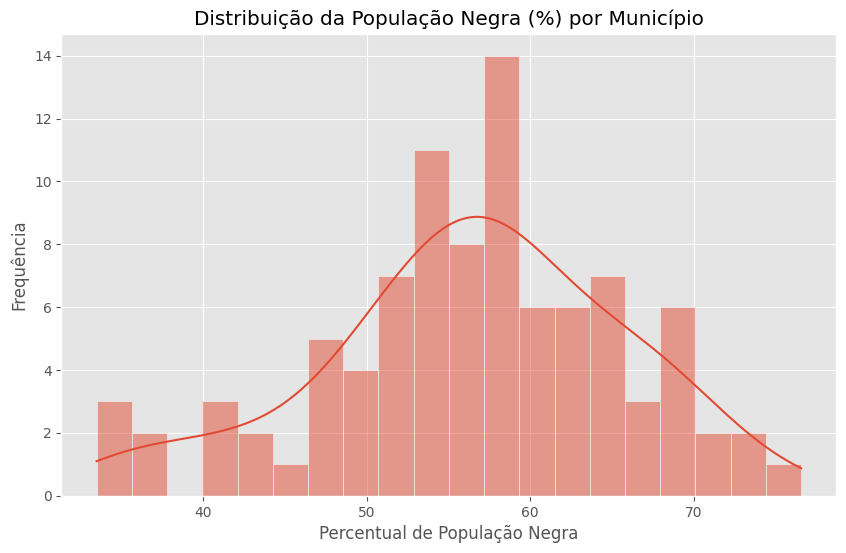

In [29]:
# Visualização da distribuição da população negra com Matplotlib e Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(dados['NEGRA%'], bins=20, kde=True)
plt.title('Distribuição da População Negra (%) por Município')
plt.xlabel('Percentual de População Negra')
plt.ylabel('Frequência')
plt.show()

In [49]:
# Carregar os dados de esgotamento sanitário
caminho_esgoto = caminho_das_bases + '/Esgotamento_Sanitario_Raca_RJ.xlsx'
df_esgoto = pd.read_excel(caminho_esgoto)
df_esgoto.rename(columns={'CD_MUN': 'id'}, inplace=True)

In [50]:
# Tratar os dados de esgotamento sanitário
df_esgoto = ajustar_populacao(df_esgoto, 'Pop_Total_Muni')


In [51]:
dados.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'CD_MESO', 'NM_MESO',
       'COD_IBGE', 'municipio', 'id', 'MUNICIPIO', 'TOTAL', 'BRANCA', 'PRETA',
       'AMARELA', 'PARDA', 'INDIGENA', 'IGNORADOS', 'BRANCA%', 'PRETA%',
       'AMARELA%', 'PARDA%', 'INDIGENA%', 'NEGRA', 'NEGRA%',
       'FAIXA_PERCENTUAL_NEGROS'],
      dtype='object')

In [56]:
df_esgoto.merge(dados, left_on='id', right_on='id', how='inner')
df_esgoto[df_esgoto['Cor ou raça'] == 'Branca']
df_esgoto['Cor ou raça'] = df_esgoto['Cor ou raça'].replace('Preta', 'Negra')
df_esgoto['Cor ou raça'] = df_esgoto['Cor ou raça'].replace('Parda', 'Negra')

In [57]:
df_esgoto.head()


,CD_MESO,NM_MESO,MUNICIPIO,id,Pop_Total_Muni,Cor ou raça,Total,"Rede geral, rede pluvial ou fossa ligada à rede",Rede geral ou pluvial,Fossa séptica ou fossa filtro ligada à rede,Fossa séptica ou fossa filtro não ligada à rede,Fossa rudimentar ou buraco,Vala,"Rio, lago, córrego ou mar",Outra forma,Não tinham banheiro nem sanitário,"Rede geral, rede pluvial ou fossa ligada à rede%",Rede geral ou pluvial%,Fossa séptica ou fossa filtro ligada à rede%,Fossa séptica ou fossa filtro não ligada à rede%,Fossa rudimentar ou buraco%,Vala%,"Rio, lago, córrego ou mar%",Outra forma%,Não tinham banheiro nem sanitário%
0,3305,Sul Fluminense,Angra dos Reis(RJ),3300100,83717,Branca,75099,54540,46423,8117,10489,5306,3746,746,264,8,32.61,27.76,4.85,6.27,3.17,2.24,0.45,0.16,0.00
1,3305,Sul Fluminense,Angra dos Reis(RJ),3300100,83717,Negra,18808,12826,11013,1813,2686,1873,1190,163,64,6,7.67,6.59,1.08,1.61,1.12,0.71,0.10,0.04,0.00
2,3305,Sul Fluminense,Angra dos Reis(RJ),3300100,83717,Amarela,329,232,209,23,73,21,0,1,2,0,0.14,0.12,0.01,0.04,0.01,0.00,0.00,0.00,0.00
3,3305,Sul Fluminense,Angra dos Reis(RJ),3300100,83717,Negra,72461,49247,41933,7314,11430,6635,4194,736,198,21,29.45,25.07,4.37,6.83,3.97,2.51,0.44,0.12,0.01
4,3305,Sul Fluminense,Angra dos Reis(RJ),3300100,83717,Indígena,541,135,107,28,42,349,12,1,2,0,0.08,0.06,0.02,0.03,0.21,0.01,0.00,0.00,0.00


In [58]:
df_esgoto.columns

Index(['CD_MESO', 'NM_MESO', 'MUNICIPIO', 'id', 'Pop_Total_Muni',
       'Cor ou raça', 'Total',
       'Rede geral, rede pluvial ou fossa ligada à rede',
       'Rede geral ou pluvial', 'Fossa séptica ou fossa filtro ligada à rede',
       'Fossa séptica ou fossa filtro não ligada à rede',
       'Fossa rudimentar ou buraco', 'Vala', 'Rio, lago, córrego ou mar',
       'Outra forma', 'Não tinham banheiro nem sanitário',
       'Rede geral, rede pluvial ou fossa ligada à rede%',
       'Rede geral ou pluvial%',
       'Fossa séptica ou fossa filtro ligada à rede%',
       'Fossa séptica ou fossa filtro não ligada à rede%',
       'Fossa rudimentar ou buraco%', 'Vala%', 'Rio, lago, córrego ou mar%',
       'Outra forma%', 'Não tinham banheiro nem sanitário%'],
      dtype='object')

In [59]:
# Visualização interativa com Plotly para esgotamento sanitário
fig = px.histogram(df_esgoto, x='Negra%', title='Distribuição de Esgotamento Sanitário por Raça')
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['CD_MESO', 'NM_MESO', 'MUNICIPIO', 'id', 'Pop_Total_Muni', 'Cor ou raça', 'Total', 'Rede geral, rede pluvial ou fossa ligada à rede', 'Rede geral ou pluvial', 'Fossa séptica ou fossa filtro ligada à rede', 'Fossa séptica ou fossa filtro não ligada à rede', 'Fossa rudimentar ou buraco', 'Vala', 'Rio, lago, córrego ou mar', 'Outra forma', 'Não tinham banheiro nem sanitário', 'Rede geral, rede pluvial ou fossa ligada à rede%', 'Rede geral ou pluvial%', 'Fossa séptica ou fossa filtro ligada à rede%', 'Fossa séptica ou fossa filtro não ligada à rede%', 'Fossa rudimentar ou buraco%', 'Vala%', 'Rio, lago, córrego ou mar%', 'Outra forma%', 'Não tinham banheiro nem sanitário%'] but received: Negra%

In [ ]:
# Criar mapa choropleth para visualização geoespacial
mapa = criar_mapa_choropleth(dados, 'NEGRA%', 'Percentual de População Negra')
mapa.save(caminho_das_bases + '/MapaNegrosMunicipiosRJ.html')

In [ ]:
# Funções Utilitárias

def carregar_dados_geograficos(caminho_geojson):
    """Carrega os dados geográficos a partir de um arquivo GeoJSON."""
    gdf = gpd.read_file(caminho_geojson)
    gdf['CD_MUN'] = gdf['CD_MUN'].astype(int)
    print(f"Dados geográficos carregados: {gdf.shape[0]} registros.")
    return gdf

def carregar_dados_estatisticos(caminho_csv, caminho_excel1, caminho_excel2):
    """Carrega os dados estatísticos de esgotamento, lixo e água."""
    esgoto = pd.read_csv(caminho_csv)
    lixo = pd.read_excel(caminho_excel1)
    agua = pd.read_excel(caminho_excel2)
    print("Dados estatísticos carregados.")
    return esgoto, lixo, agua

def merge_dados_geograficos(gdf, df_estatistico, coluna_geografica, coluna_estatistica):
    """Faz o merge dos dados geográficos com os estatísticos."""
    merged = gdf.merge(df_estatistico, left_on=coluna_geografica, right_on=coluna_estatistica, how='left')
    print(f"Merge realizado: {merged.shape[0]} registros.")
    return merged

def tratar_percentuais(df, colunas):
    """Converte as colunas de percentual para o tipo float e substitui vírgulas por pontos."""
    for coluna in colunas:
        df[coluna] = df[coluna].str.replace(',', '.').astype(float)
    return df

def calcular_centroides(df):
    """Calcula os centroides das geometrias e adiciona colunas de latitude e longitude."""
    df['latitude'] = df['geometry'].centroid.y
    df['longitude'] = df['geometry'].centroid.x
    return df

def plotar_setores_censitarios(gdf, titulo):
    """Plota os setores censitários em um gráfico com título especificado."""
    ax = gdf.plot(figsize=(10, 10))
    ax.set_title(titulo)
    plt.show()

def criar_mapa_interativo_com_circulos(gdf):
    """Cria um mapa interativo com os dados geográficos e adiciona círculos representando a proporção de população negra."""
    mapa = folium.Map(location=[-22.9, -43.2], zoom_start=8)
    folium.GeoJson(gdf).add_to(mapa)

    # Adicionar círculos interativos ao mapa
    for i in range(len(gdf)):
        folium.Circle(
            location=[gdf.iloc[i]['latitude'], gdf.iloc[i]['longitude']],
            color='#00FF69',
            fill=True,
            fill_color='#00A1B3',
            tooltip=('<li><b>Município:</b> ' + str(gdf.iloc[i]['NM_MUN']) + '</li>' +
                     '<li><b>Representatividade:</b> ' + str(round(gdf.iloc[i]['Negra%'], 2)) + '%</li>'),
            radius=(gdf.iloc[i]['Negra%'] ** 2)
        ).add_to(mapa)

    return mapa

In [ ]:
# Caminhos dos arquivos
caminho_geojson = 'RJ_Malha_Preliminar_Distrito_2022.json'
caminho_esgoto = 'NegrosEsgoto_EsgotoRJ.csv'
caminho_lixo = 'NegrosBrancosLixo.xlsx'
caminho_agua = 'NegrosBrancos_Agua.xlsx'

In [ ]:
# Carregar dados geográficos e estatísticos
rj = carregar_dados_geograficos(caminho_geojson)
esgoto, lixo, agua = carregar_dados_estatisticos(caminho_esgoto, caminho_lixo, caminho_agua)

In [ ]:
# Merge dos dados geográficos com os dados estatísticos
dados_rj = merge_dados_geograficos(rj, esgoto, 'CD_MUN', 'COD_IBGE')

In [ ]:
# Ajuste de tipos de dados para colunas de percentuais
colunas_percentuais = ['Branca%', 'Negra%', 'Brancos_Nao_possui_Esgotamento_Sanitario%']
dados_rj = tratar_percentuais(dados_rj, colunas_percentuais)

In [ ]:
# Cálculo dos centroides geográficos
dados_rj = calcular_centroides(dados_rj)

In [ ]:
# Plotagem dos setores censitários
plotar_setores_censitarios(dados_rj, 'Setores Censitários - Estado RJ')

In [ ]:
# Criação do mapa interativo com círculos
mapa_interativo_com_circulos = criar_mapa_interativo_com_circulos(dados_rj)
mapa_interativo_com_circulos.save('Mapa_Interativo_Circulos_Setores_Censitarios.html')

In [ ]:
# Exibir mapa interativo
mapa_interativo_com_circulos